In [1]:
import math
import random
import numpy as np
import torch 
import torch.optim as optim
import torch.nn as nn
from copy import deepcopy
import asyncio
import nest_asyncio
from HP2D_Env import HP2D
from MCTS import MCTS
from models import DualRes
from tqdm import tqdm
import time
from IPython.display import clear_output
nest_asyncio.apply()

In [2]:
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("Using GPU: GPU requested and available.")
    dtype = torch.cuda.FloatTensor
    dtypelong = torch.cuda.LongTensor
else:
    print("NOT Using GPU: GPU not requested or not available.")
    dtype = torch.FloatTensor
    dtypelong = torch.LongTensor

Using GPU: GPU requested and available.


In [3]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, prob, value):
        state = np.expand_dims(state, 0)
        self.buffer.append((state, prob, value))

    def sample(self, batch_size):
        state, prob, value = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), prob, value

    def __len__(self):
        return len(self.buffer)
    
replay_size = 10000
replay_buffer = ReplayBuffer(replay_size)

In [4]:
dualres = DualRes(10, 4, USE_CUDA)
best_player = deepcopy(dualres)

if USE_CUDA:
    dualres = dualres.cuda()
    best_player = best_player.cuda()

In [5]:
test_model = DualRes(10, 4, USE_CUDA, blocks_sizes = [64], deepths = [2])
if USE_CUDA:
    test_model = test_model.cuda()

In [6]:
class AlphaLoss(nn.Module):
    def __init__(self):
        super(AlphaLoss, self).__init__()
        
    def forward(self, pred_v, v, pred_p, p):
        ve = nn.MSELoss(reduction = 'none')
        v_err = ve(pred_v.view(-1), v)
        p_err = torch.sum((-p * (1e-15 + pred_p).log()), dim = 1)
        tot_err = (v_err + p_err).mean()
        return tot_err

In [7]:
def compute_loss(net, batch_size, replay_buffer, optimizer, criterion):
    state, p, v = replay_buffer.sample(batch_size)
    state = torch.tensor(np.float32(state)).type(dtype)
    p = torch.tensor(np.float32(p)).type(dtype)
    v = torch.tensor(v).type(dtype)
    
    pred_p, pred_v = net(state)
    loss = criterion(pred_v, v, pred_p, p)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [8]:
def hard_update(q_network, target_q_network):
    for t_param, param in zip(target_q_network.parameters(), q_network.parameters()):
        if t_param is param:
            continue
        new_param = param.data
        t_param.data.copy_(new_param)

In [9]:
file = open('seqs.txt', 'r')
seq_list = file.readlines()
max_length = 5
# Get sequences with length <= max_length
seqs = [s for s in seq_list if len(s) <= max_length + 1]
test_seqs = random.sample(seqs, len(seqs) // 10)
train_seqs = [s for s in seqs if s not in test_seqs]

In [10]:
len(seqs)

48

In [11]:
async def train():
    criterion = AlphaLoss()
    optimizer = optim.SGD(test_model.parameters(), lr = 0.0001, momentum = 0.9, weight_decay = 0.0001)
    
    loss = compute_loss(test_model, batch_size, replay_buffer, optimizer, criterion)
    return loss

In [12]:
async def play(num_iter, num_games):
    '''
    Plays num_games games with the current network.
    For each game, adds len(seq) - 1 data points (s_t, pi_t, z_t) to replay buffer.
    '''
    for g in range(num_games):
        seq = random.sample(train_seqs, 1)[0][:-1]
        # print("Game {} / {}: {}".format(g + 1, num_games, seq))
        env = HP2D(seq, (10,11,11))
        states = []
        probs = []
        state = env.make_state()
        for t in range(len(seq) - 1):
            temp = int(t < len(seq) // 10)
            mcts = MCTS(env, test_model, num_iter, cpuct = 5)
            pi_t = mcts.get_prob(state, temp = temp)
            sym = get_syms(state, pi_t)
            for s, p in sym:
                states.append(s)
                probs.append(p)
            action = np.random.choice(len(pi_t), p = pi_t)
            state = env.next_state(state, action)
        reward = env.calc_score(states[-1])
        for i in range(len(states)):
            replay_buffer.push(states[i], probs[i], reward)

In [13]:
async def evaluate(num_iter):
    '''
    Evaluates using 10 games with current network, compare results to hypothetical maximum.
    Returns a float between (0, 1): score / hyp_max score
    '''
    seqs = test_seqs
    total = 0
    for s in seqs:
        env = HP2D(s[:-1], (10,11,11))
        state = env.make_state()
        for t in range(len(s) - 1):
            mcts   = MCTS(env, test_model, num_iter, cpuct = 5)
            pi     = mcts.get_prob(state, temp = 0)
            action = np.random.choice(len(pi), p = pi)
            state  = env.next_state(state, action)    
        total += env.calc_score(state) / (env.hyp_max() + 1e-6)
    return total / 10

In [14]:
def get_syms(state, pi):
    """
    Input:
        board: current board
        pi: policy vector of size self.get_prob()
    Returns:
        symmForms: a list of [(board,pi)] where each tuple is a symmetrical
                   form of the board and the corresponding pi vector. This
                   is used when training the neural network from examples.
    """
    assert(len(pi) == 4)
    l = []
    
    def rotate(pi, n):
        for _ in range(n):
            temp = pi
            pi = [temp[1], temp[3], temp[0], temp[2]]
        return pi
    
    def flip(pi):
        return [pi[3], pi[1], pi[2], pi[0]]
        
    for i in range(1, 5):
        for j in [True, False]:
            new_state = np.rot90(state, i, (1, 2))
            new_pi = rotate(pi, i)
            if j:
                new_state = np.fliplr(new_state)
                new_pi = flip(new_pi)
            l += [(new_state, new_pi)]
    return l

In [15]:
async def main(num_timesteps, num_games, num_iter, batch_size):
    '''
    Executing play, train, evaluate asynchronously in parallel.
    '''

    losses = []
    scores = []

    for ts in tqdm(range(1, num_timesteps + 1)):
        # clear_output(wait = True)
        # print('Timestep {} / {}'.format(ts, num_timesteps))
        flag = False
        
        # Data generation
        playing = loop.create_task(play(num_iter, num_games))

        # Update params
        if len(replay_buffer) > batch_size:
            training = loop.create_task(train())
            flag = True
        
        # Evaluate agent
        if ts % 200 == 0:
            evaluating = loop.create_task(evaluate(num_iter))
            await asyncio.wait([playing, training, evaluating])
            
            score = evaluating.result()
            scores.append(score)
        else:
            if flag:
                await asyncio.wait([playing, training])
            
                loss = training.result()
                losses.append(loss)
            else:
                await asyncio.wait([playing])

    return losses, scores

In [35]:
num_timesteps = 3000
num_games = 15
num_iter = 10
batch_size = 32

loop = asyncio.get_event_loop()

losses, scores = loop.run_until_complete(main(num_timesteps, num_games, num_iter, batch_size))

100%|██████████| 3000/3000 [54:48<00:00,  1.10s/it]


In [17]:
# torch.save(dualres.state_dict(), 'PFZeroNet.pt')

In [18]:
# model = DualRes(10, 4, USE_CUDA)
# if USE_CUDA:
#     model = model.cuda()
# model.load_state_dict(torch.load('PFZeroNet.pt'))

In [19]:
torch.save(test_model.state_dict(), 'Test.pt')

In [43]:
testenv = HP2D('HPPH', (10, 11, 11))
teststate = testenv.make_state()
testpi, testv = test_model.predict(teststate)
print(testpi, testv)
teststate = testenv.next_state(teststate, 0)
testpi, testv = test_model.predict(teststate)
print(testpi, testv)
teststate = testenv.next_state(teststate, 0)
testpi, testv = test_model.predict(teststate)
print(testpi, testv)
teststate = testenv.next_state(teststate, 0)
testpi, testv = test_model.predict(teststate)
print(testpi, testv)

[0.2630686  0.24845055 0.2528621  0.23561874] [-0.26936343]
[0.26304305 0.24910915 0.25140432 0.23644358] [-0.28223464]
[0.2630686  0.24845055 0.2528621  0.23561874] [-0.26434737]
[0.2630686  0.24845055 0.2528621  0.23561874] [-0.28196374]


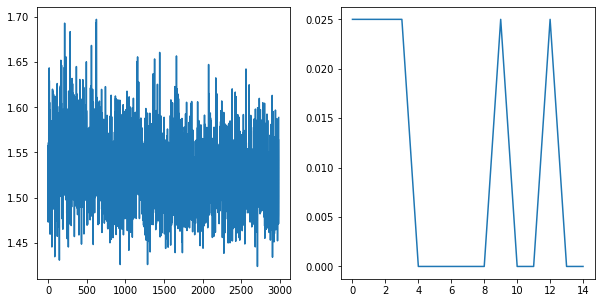

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (10, 5))
ax = plt.subplot(1,2,1)
plt.plot(losses)
ax = plt.subplot(1,2,2)
plt.plot(scores)

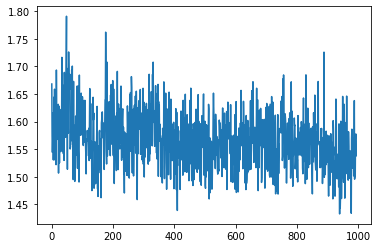

In [28]:
plt.plot(losses)

In [39]:
scores

[0.02499998750000625,
 0.02499998750000625,
 0.02499998750000625,
 0.02499998750000625,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.02499998750000625,
 0.0,
 0.0,
 0.02499998750000625,
 0.0,
 0.0]

In [24]:
criterion = AlphaLoss()
optimizer = optim.SGD(test_model.parameters(), lr = 0.0001, momentum = 0.9, weight_decay = 0.0001)
    

state, p, v = replay_buffer.sample(2)
state = torch.tensor(np.float32(state)).type(dtype)
p = torch.tensor(np.float32(p)).type(dtype)
v = torch.tensor(v).type(dtype)

pred_p, pred_v = test_model(state)
loss = criterion(pred_v, v, pred_p, p)
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [32]:
losses

[tensor(1.6681, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.5738, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.5443, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.5646, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.6160, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.5306, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.5706, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.6442, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.5307, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.6587, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.5901, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.6411, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.6069, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.6567, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.5220, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.6933, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.6092, device='cuda:0', grad_fn=<MeanBackward0>

In [36]:
losses_list += losses

In [37]:
len(losses_list)

3980